In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

# Define the model
from net import Net

# Optimizer and loss function
import torch.optim as optim
import torch.nn as nn


In [4]:
# indicates that "1" means "face" and "0" non-face (only used for display)
classes = ('noface', 'face')

# Defining the folder path
train_dir = './train_images'    # folder containing training images
test_dir = './test_images'    # folder containing test images

# Define the functions

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# function to switch to cuda if available
def switch_to_cuda(model):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        model.to(device)
        print("switch to cuda")
        return True, device
    print("cuda not available")
    return False, None


# function to train the model with GPU
def train_GPU(model, train_loader, criterion, optimizer, epochs, device):
    for epoch in range(1, epochs+1):
        # Mode d'entraînement
        model.train()
        running_loss = 0.0
        for data, target in train_loader:

            # Passage en mode CUDA
            data, target = data.to(device), target.to(device)
            # Mise à zéro des gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data)
            # Calcul de la perte
            loss = criterion(outputs, target)
            # Backpropagation et mise à jour des poids
            loss.backward()
            optimizer.step()
            # Suivi de la perte
            running_loss += loss.item()

        # Affichage de la perte moyenne de l'époque
        print(f'Epoch {epoch}, Loss: {running_loss / len(train_loader)}')

    print('Finished Training')

# function to train model with CPU
def train_CPU(model, train_loader, criterion, optimizer, epochs):
    for epoch in range(1, epochs+1):
        # Mode d'entraînement
        model.train()
        running_loss = 0.0
        for data, target in train_loader:

            # Mise à zéro des gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data)
            # Calcul de la perte
            loss = criterion(outputs, target)
            # Backpropagation et mise à jour des poids
            loss.backward()
            optimizer.step()
            # Suivi de la perte
            running_loss += loss.item()

        # Affichage de la perte moyenne de l'époque
        print(f'Epoch {epoch}, Loss: {running_loss / len(train_loader)}')
    print('Finished Training')

# function to measure the accuracy of the model
def accuracy(model, test_loader):
    model.to(torch.device("cpu"))
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

# function to measure the accuracy of the model for each class
def accuracy_per_class(model, test_loader):
    model.to(torch.device("cpu"))
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in test_loader:
            # data = data.to(device)
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


## Preparing environment and data

In [5]:


# Transforming the images for the neural network
transform = transforms.Compose(
    [transforms.Grayscale(),   # transforms to gray-scale (1 input channel)
     transforms.ToTensor(),    # transforms to Torch tensor (needed for PyTorch)
     transforms.Normalize(mean=(0.5,), std=(0.5,))])  # subtracts mean (0.5) and devides by standard deviation (0.5) -> resulting values in (-1, +1)

# Define two pytorch datasets (train/test)
train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

valid_size = 0.2   # proportion of validation set (80% train, 20% validation)
batch_size = 32

# Define randomly the indices of examples to use for training and for validation
num_train = len(train_data)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:], indices_train[:split_tv]

# Define two "samplers" that will randomly pick examples from the training and validation set
train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Dataloaders (take care of loading the data from disk, batch by batch, during training)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=True, num_workers=1)

### Data visualization

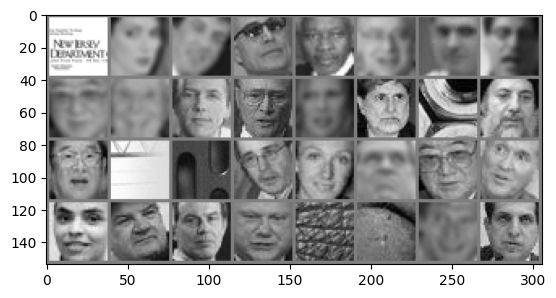

noface face  face  face  face  face  face  face  face  face  face  face  face  face  noface face  face  noface noface face  face  face  face  face  face  face  face  face  noface noface face  face 


In [6]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


## Training

In [13]:
# Instance of the model
model = Net()
# Model summary
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
n_epochs = 3  # Nb of epochs

cuda = switch_to_cuda(model)  # Switch to cuda if available

if cuda:
    train_GPU(model, train_loader, criterion, optimizer, n_epochs)
else:
    train_CPU(model, train_loader, criterion, optimizer, n_epochs)


cuda not available
Epoch 1, Loss: 0.30590005462759323
Epoch 2, Loss: 0.08095116161294948
Epoch 3, Loss: 0.039860303742576327
Finished Training


## Evaluation

In [16]:
# Evaluation
model.eval()

# Accuracy
accuracy(model, test_loader)

# Accuracy per class
accuracy_per_class(model, test_loader)

Accuracy of the network on the 10000 test images: 92 %
Accuracy for class: noface is 98.2 %
Accuracy for class: face  is 39.5 %


Upon evaluating the model's performance for each category, it becomes evident that the network struggles to correctly classify instances belonging to the "face" category. This observation prompts the need for a deeper investigation into the underlying causes of this misclassification and the development of effective strategies for mitigation.

#### Issues

1. **Classification Challenge**: The model consistently exhibits lower accuracy when classifying "face" instances compared to the "noface" category.

##### Solutions

##### **Data Proportion Adjustment**

- **Issue**: There is a suspicion of overfitting on the "noface" data due to an imbalanced dataset.

- **Solution**: One approach is to adapt the proportion of "face" and "noface" data in the training set to mitigate the risk of overfitting. By oversampling "face" data or undersampling "noface" data, we can create a more balanced dataset.

##### **Class Weight Modification**

- **Issue**: The class imbalance might lead to the model assigning less importance to the "face" class during training.

- **Solution**: We can adjust the class weights in the loss function (e.g., Cross Entropy Loss) to give more weight to the minority class, which is "face" in this case. By increasing the weight for "face," the model becomes more sensitive to it during training.

##### **Early Stopping**

- **Issue**: The model may be overfitting the training data, and it might not generalize well to unseen examples.

- **Solution**: Implement early stopping during training. This involves monitoring the loss on a validation set and stopping training when the loss reaches a minimum value, thus preventing the model from memorizing the training data.

##### **Data Augmentation**

- **Issue**: The model's inability to classify "face" instances could be due to variations in the orientation or presentation of "face" data.

- **Solution**: Apply data augmentation techniques, such as rotating or flipping "face" data during training. This introduces diversity in the training set and helps the model become more robust to different orientations.

#### Conclusion

Addressing the classification challenges for the "face" category is essential to improve the overall performance of the model. The proposed solutions aim to counteract issues related to data imbalance, overfitting, and model generalization, with the goal of achieving more accurate and reliable results.


## Weight

In [4]:
#  Weight face data
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01)
n_epochs = 3  # Nb of epochs
# Define your class weights
weight_for_face = 5.0
class_weights = torch.tensor([1.0, weight_for_face])
criterion = nn.CrossEntropyLoss(weight=class_weights)


cuda = switch_to_cuda(model)

if cuda:
    train_GPU(model, train_loader, criterion, optimizer, n_epochs)
else:
    train_CPU(model, train_loader, criterion, optimizer, n_epochs)

cuda not available
Epoch 1, Loss: 0.1939981686247036
Epoch 2, Loss: 0.06617774704653596
Epoch 3, Loss: 0.0449690333095603
Finished Training


The first time I re did it, i forgot to set the model as new. So it trainned a model already trainned.
I got an accuracy for faces of 45%, which is significantly better than before.
Nonetheless, I had to do it again initializing the model as new, decreasing the final accuracy.

In [5]:
# Evaluation
model.eval()

# Accuracy
accuracy(model, test_loader)

# Accuracy per class
accuracy_per_class(model, test_loader)

Accuracy of the network on the 10000 test images: 86 %
Accuracy for class: noface is 90.9 %
Accuracy for class: face  is 51.4 %


In an effort to improve the model's performance, we implemented the use of class weights with a weight of 5 for the "face" category during training. The initial results after 3 epochs of training are as follows:

- Accuracy for class "noface" is 90.9%.
- Accuracy for class "face" is 51.4%.


We have observed a light improvement in the accuracy of the "face" class, with an increase of 10 percentage points. However, there is room for further enhancement. In light of these results, we propose additional strategies to refine the model's performance.

- **Computational Limitations**: Recognizing that resource constraints can be a limiting factor, we acknowledge that extensive hyperparameter tuning and data augmentation can be computationally intensive. We may need to strike a balance between resource availability and model improvement.

### Conclusion

The initial implementation of class weights has demonstrated a substantial increase in the accuracy of the "face" class. However, we recognize the potential for further refinement. By systematically exploring hyperparameter settings, utilizing Early Stopping, and considering data augmentation, we aim to maximize the model's performance while respecting computational constraints.


## Data augmentation

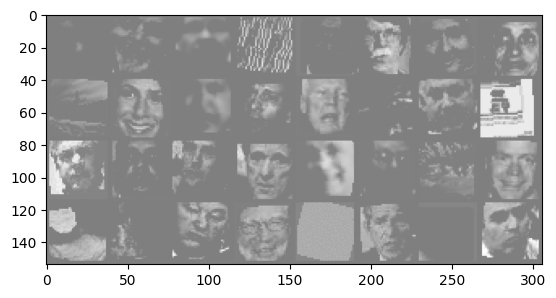

face  face  face  noface face  face  face  face  noface face  face  face  face  noface face  noface face  face  face  face  face  face  noface face  noface noface face  face  noface face  noface face 


In [5]:
# Data augmentation transformation
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
    # New transformations
    transforms.RandomRotation(degrees=15),  # Random rotation of -15° to +15°
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    # Random translation of -10% to +10% on both axes
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    # Luminozity and contrast jitter
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
])

# Define two pytorch datasets (train/test)
train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

valid_size = 0.2   # proportion of validation set (80% train, 20% validation)
batch_size = 32

# Define randomly the indices of examples to use for training and for validation
num_train = len(train_data)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:], indices_train[:split_tv]

# Define two "samplers" that will randomly pick examples from the training and validation set
train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Dataloaders (take care of loading the data from disk, batch by batch, during training)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=True, num_workers=1)

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [6]:
# Instance of the model
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
n_epochs = 3  # Nb of epochs
cuda, device = switch_to_cuda(model)  # Switch to cuda if available

if cuda:
    train_GPU(model, train_loader, criterion, optimizer, n_epochs, device)
else:
    train_CPU(model, train_loader, criterion, optimizer, n_epochs)

switch to cuda


In [ ]:
# Evaluation
model.eval()

# Accuracy
accuracy(model, test_loader)

# Accuracy per class
accuracy_per_class(model, test_loader)

Accuracy of the network on the 10000 test images: 86 %
Accuracy for class: noface is 86.3 %
Accuracy for class: face  is 84.2 %


- Accuracy for class: noface is 81.0 %
- Accuracy for class: face  is 86.3 %

- optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
- criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
- n_epochs = 3  # Nb of epochs


- Accuracy for class: noface is 88.4 %
- Accuracy for class: face  is 81.6 %

Without weight_decay.

With dropout 0.5:

- Accuracy for class: noface is 87.0 %
- Accuracy for class: face  is 78.8 %

With dropout and more kernels:
- Accuracy for class: noface is 86.3 %
- Accuracy for class: face  is 84.2 %

In [ ]:
# Save the model
PATH = './model.pth'
torch.save(model.state_dict(), PATH)